In [1]:
import arsenal_gear as ag
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u

from time import time

In [6]:
sp = ag.StellarPopulation(interp_op="eep")

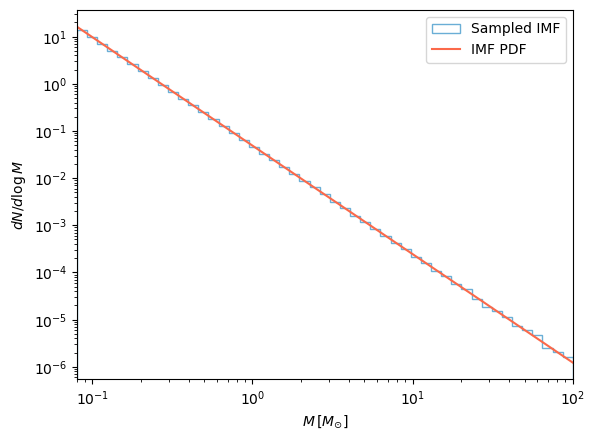

In [7]:
mbins = np.logspace(np.log10(sp.imf.min_mass), np.log10(sp.imf.max_mass), 50)

plt.hist(sp.masses.value, bins=mbins,density=True,histtype='step',color=plt.cm.Blues(0.5),label="Sampled IMF")
plt.plot(mbins, sp.imf._pdf(mbins), color=plt.cm.Reds(0.5), label="IMF PDF")

plt.yscale("log")
plt.xscale("log")
plt.xlim(sp.imf.min_mass, sp.imf.max_mass)
plt.xlabel(r"$M \, [M_{\odot}]$")
plt.ylabel(r"$dN/d\log M$")
plt.legend()

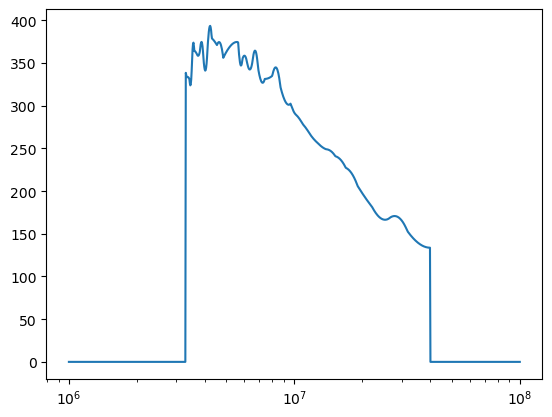

In [8]:
tlin = np.logspace(6,8,1000)*u.yr
plt.plot(tlin, sp.ndotsn(tlin), label="Cumulative SNe")
plt.xscale("log")

Isochrone interpolation time: 2.3228 s
Isochrone construction time: 1.1053 s


(-2.0, 6.0)

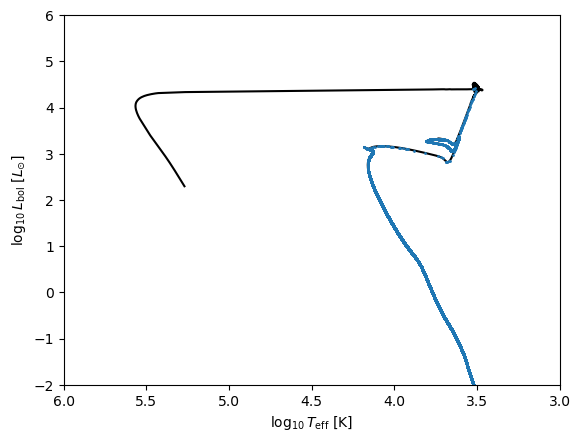

In [9]:
t = np.array([100])*u.Myr
timing = -1*time()
Lbol = sp.lbol_iso(t)
Teff = sp.teff_iso(t)
timing += time()
print(f"Isochrone interpolation time: {timing:.4f} s")

timing = -1*time()
iso = sp.iso.construct_isochrone(t)
timing += time()
print(f"Isochrone construction time: {timing:.4f} s")
plt.plot(iso.qs[iso.lteff_name], iso.qs[iso.llbol_name],'k-')
plt.plot(np.log10(Teff.value), np.log10(Lbol.value), 'o',ms=1)

plt.xlabel(r"$\log_{10} T_{\rm eff}$ [K]")
plt.ylabel(r"$\log_{10} L_{\rm bol}$ [$L_{\odot}$]")
plt.xlim(6,3)
plt.ylim(-2,6)